# Delay Lines experiments

**Source**:
* Sean Luke, 2019, Computational Music Synthesis, zeroth edition, available for free at http://cs.gmu.edu/~sean/book/synthesis/ 
* Smith, J.O. "Delay Lines", in 
Physical Audio Signal Processing,
https://ccrma.stanford.edu/~jos/pasp/Acoustic_Modeling_Digital_Delay.html, online book, 
2010 edition, accessed Feb 2021.

## Delay

In [19]:
from scipy.io import wavfile

samplerate, data = wavfile.read('data/guitar_short.wav')

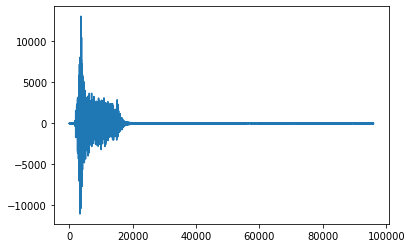

In [20]:
import matplotlib.pyplot as plt

plt.plot(data)

In [21]:
import numpy as np

def humble_delay(signal):
    N = len(signal)
    y = np.zeros(N)
    # 0.5s delay        s = ndelay / samplerate
    delay = int(0.5 * samplerate)
    buffer = np.zeros(delay)
    dry_vol = 0.5
    wet_vol = 0.5
    # delay line
    p = 0
    for x in range(N):
        y[x] = signal[x]*dry_vol + buffer[p]*wet_vol
        buffer[p] = signal[x]
        p += 1
        if p >= len(buffer):
            p = 0
    return y

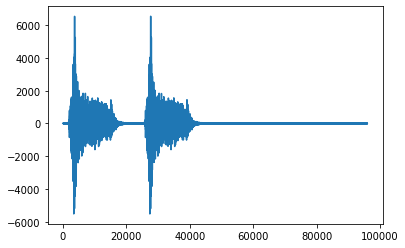

In [22]:
adelay = humble_delay(data)
plt.plot(adelay)
wavfile.write('adelay.wav', samplerate, adelay.astype(np.int16))

In [23]:
import numpy as np 

def feedback_delay(signal):
    N = len(signal)
    y = np.zeros(N)
    # delay 0.5s
    delay = int(samplerate * 0.5)
    buffer = np.zeros(delay)
    dry_out = 1
    wet_out = 0.7
    feedback = 0.5
    p = 0
    for x in range(N):
        y[x] = signal[x]*dry_out + buffer[p]*wet_out
        buffer[p] = (buffer[p] + signal[x]) * feedback
        p += 1
        if p >= delay:
            p = 0
    return y

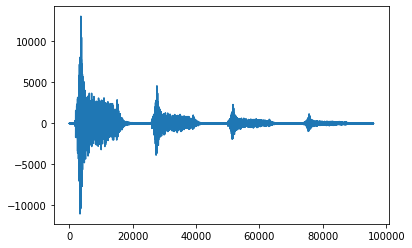

In [24]:
from scipy.io import wavfile

fdelay = feedback_delay(data)
plt.plot(fdelay)
wavfile.write('fdelay.wav', samplerate, fdelay.astype(np.int16))

## Comb Filter


In [4]:
from scipy import fft
import matplotlib.pyplot as plt
import numpy as np

'''
    "data" is an array of signals.
    "nyquist" sets if it should take in count
    the nyquist frequency when plotting.
    "f_normal" to see the frequency range in 
    normalized range.

    source:
        https://www.gaussianwaves.com/2015/11/interpreting-fft-results-complex-dft-frequency-bins-and-fftshift/
'''
def plot_fft(data, nyquist = False, f_normal = False):
    plt.figure(figsize=(20, 5))
    for d in data:
        # sample_freq = fft.fftfreq(d.size, d=(1/samplerate))
        sig_freq = fft.fft(d)
        N = len(d)
        df = samplerate/N
        if nyquist:
            N = int(N/2)
            sig_freq = sig_freq[:N]
        sample_index = np.arange(N)
        f = sample_index*df
        # normalize sig freq
        Y = (sig_freq - np.min(sig_freq)) / (np.max(sig_freq) - np.min(sig_freq))
        if f_normal:
            f = (f - np.min(f)) / (np.max(f) - np.min(f))
        plt.plot(f, np.abs(Y))

    plt.show()

In [3]:
from scipy.io import wavfile

samplerate, data = wavfile.read('data/white_noise.wav')

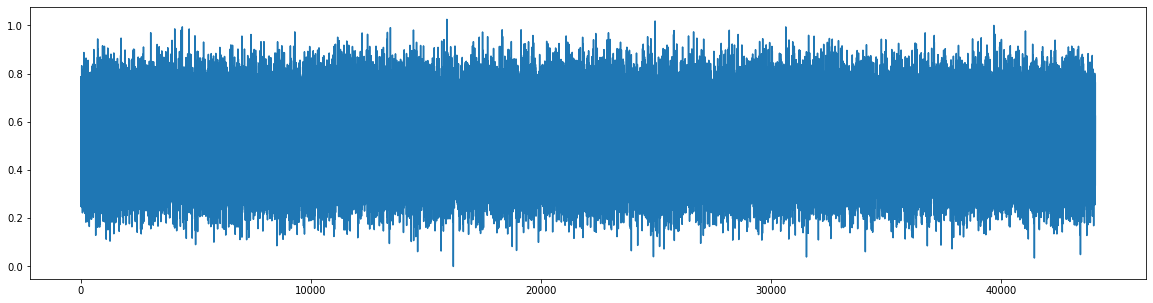

In [4]:
plot_fft([data])

In [5]:
import numpy as np

'''
    Feed Forward Comb Filter
'''
def comb_filter(signal):
    N = len(signal)
    y = np.zeros(N)
    # * filter parameters
    depth = 0.9
    # delay = int(samplerate * 0.021)   # 0.0xxs delay = xxms
    delay = 5   # 5 samples
    # * ring buffer
    buffer = np.zeros(delay)  
    p = 0
    for i in range(N):
        y[i] = signal[i] + buffer[p]*depth
        buffer[p] = signal[i]
        p += 1
        if p >= delay:
            p = 0
    return y

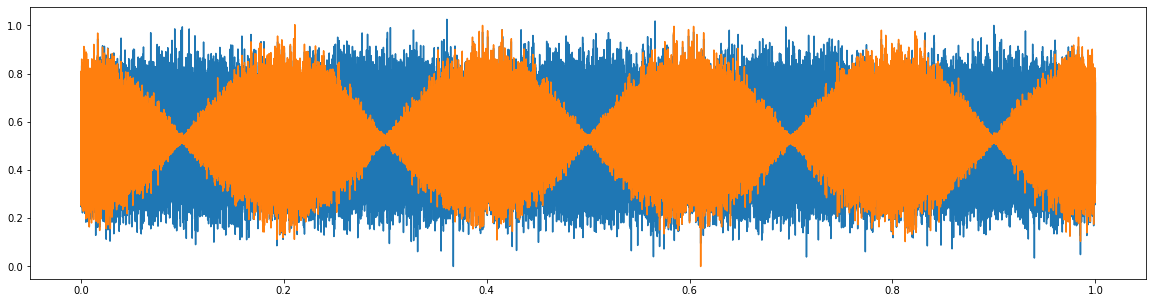

In [6]:
plot_fft([data,comb_filter(data)], f_normal=True)

In [7]:
import numpy as np

'''
    Feedback Comb Filter
'''
def fcomb_filter(signal):
    N = len(signal)
    y = np.zeros(N)
    # * filter parameters
    depth = 0.9
    # delay = int(samplerate * 0.021)  
    delay = 5
    # * ring buffer
    buffer = np.zeros(delay)
    p = 0
    for i in range(N):
        y[i] = signal[i] + buffer[p]*depth
        buffer[p] = y[i]
        p += 1
        if p >= delay:
            p = 0
    return y

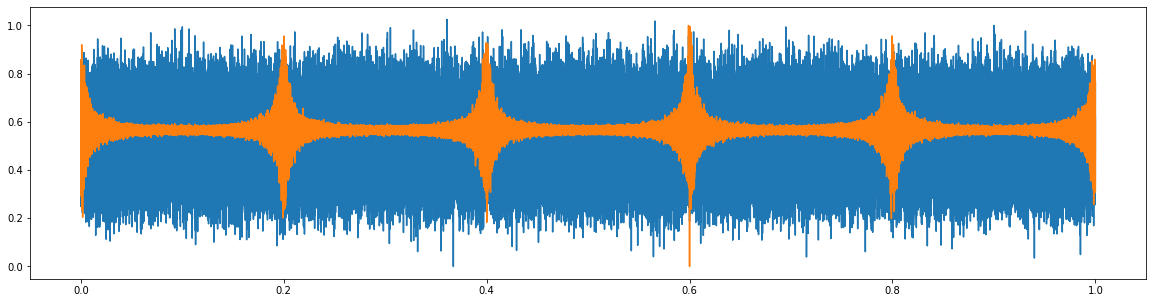

In [8]:
plot_fft([data, fcomb_filter(data)], f_normal=True)

In [9]:
from scipy.io import wavfile

samplerate, guitar = wavfile.read('data/guitar.wav')

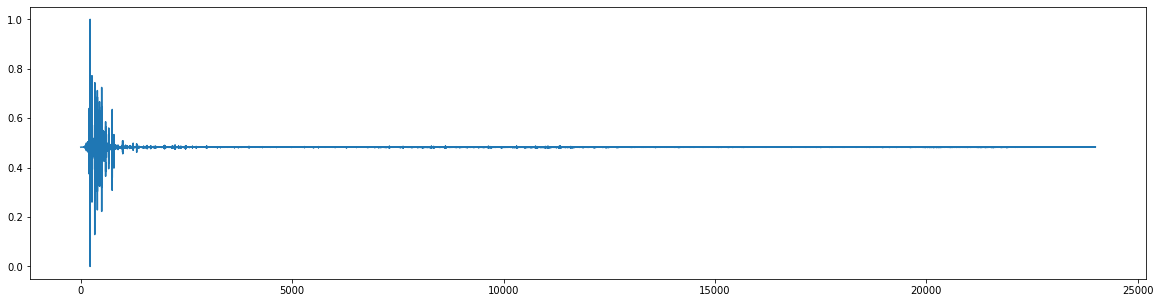

In [10]:
plot_fft([guitar], nyquist=True)

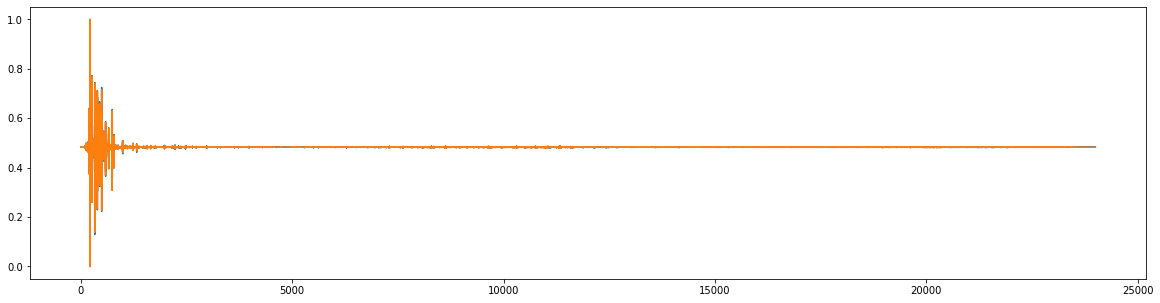

In [11]:
plot_fft([guitar,comb_filter(guitar)], nyquist=True)

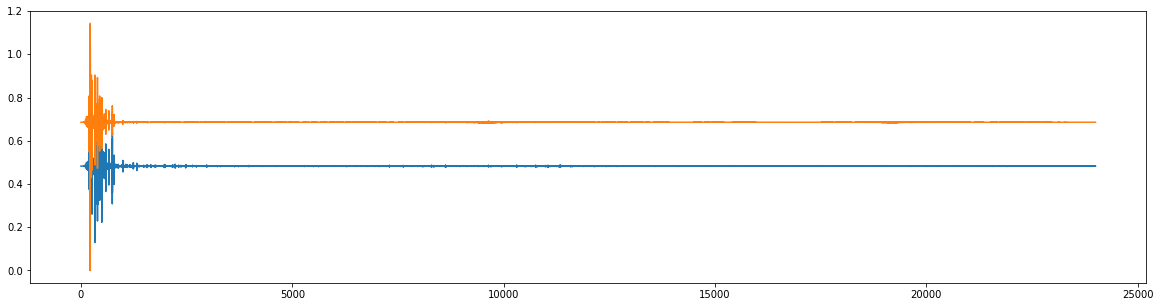

In [12]:
plot_fft([guitar,fcomb_filter(guitar)], nyquist=True)

## Allpass Filter

In [20]:
import numpy as np 
'''
    Allpass filter
        source: https://ccrma.stanford.edu/~jos/pasp/Allpass_Two_Combs.html 
'''
def allpass(signal):
    N = len(signal)
    y = np.zeros(N)
    delay = 100
    buffer = np.zeros(delay)
    a = 0.3
    # "b0" needs to be the same as "a" or it will be a comb filter, not allpass
    # original equation is: y(n) = b0*v + v(n - m)
    # eventually: y(n) = a*v + v(n - m)
    p = 0
    for i in range(N):
        # v(n) = x(n) - a*v(n - m)
        v = signal[i] - a*buffer[p]
        # y(n) = a*v(n) + v(n - m)
        y[i] = a*v + buffer[p]
        buffer[p] = v
        p += 1
        if p >= delay:
            p = 0
    return y

In [18]:
from scipy.io import wavfile

samplerate, data = wavfile.read('data/white_noise.wav')

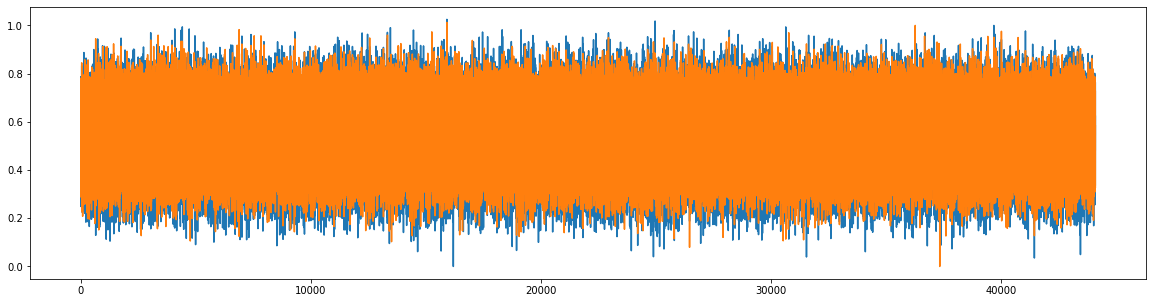

In [21]:
plot_fft([data,allpass(data)])

## Flanger


In [4]:
import numpy as np

TWO_PI = np.pi * 2

class Sine:
    __freq = 0
    __time = 0
    __t_samples = 0
    __unipolar = False
    def __init__(self, freq, samplerate = 44100, unipolar = False):
        self.__freq = freq
        self.__t_samples = 1 / samplerate
        self.__unipolar = unipolar
    
    def tick(self):
        # y(t) = A*sin(2pi*f*t + p)
        if self.__unipolar:
            y = (np.sin(TWO_PI*self.__freq*self.__time)*0.5)+0.5
        else:
            y = np.sin(TWO_PI*self.__freq*self.__time)
        self.__time += self.__t_samples
        return y

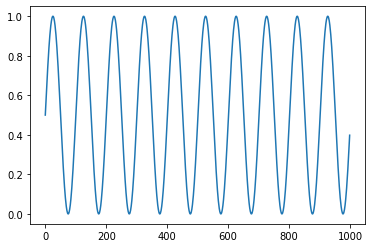

In [2]:
import matplotlib.pyplot as plt

s = 0

sine = Sine(440, unipolar=True)

d = []

for i in range(1000):
    d.append(sine.tick())

plt.plot(d)

In [3]:
def flanger_linear(signal, depth = 0.5, lfo_freq = 1):
    N = len(signal)
    y = np.zeros(N)
    sine = Sine(lfo_freq, unipolar=True)
    # * flanger parameters
    # check for better delay time
    max_delay = int(samplerate * 0.025)
    delay = int(max_delay * 0.6)
    # * ring buffer
    buffer = np.zeros(max_delay)  
    p = 0
    for i in range(N):
        n = sine.tick()
        # Liner Interpolation for fractional delays
        #   source: https://ccrma.stanford.edu/~jos/pasp/Linear_Interpolation.html 
        y[i] = signal[i] + depth*(buffer[p]*(1-n) + buffer[p+1]*n)
        buffer[p] = signal[i]
        p += 1
        if p >= delay:
            p = 0
    return y

In [4]:
from scipy.io import wavfile

samplerate, data = wavfile.read('data/guitar.wav')

In [5]:
from scipy.io import wavfile

wavfile.write('flanger-linear.wav', samplerate, flanger_linear(data).astype(np.int16))

In [6]:
from scipy.io import wavfile

samplerate, triangle = wavfile.read('data/triangle-c.wav')

In [7]:
from scipy.io import wavfile

wavfile.write('flanger-linear.wav', samplerate, flanger_linear(triangle).astype(np.int16))

In [10]:
import numpy as np

def flanger_allpass(signal, depth = 0.5, lfo_freq = 1):
    N = len(signal)
    y = np.zeros(N)
    sine = Sine(lfo_freq, unipolar=True)
    delay = int(samplerate * 0.025)
    buffer = np.zeros(delay)
    p = 0
    # y(n - 1)
    v = 0
    for i in range(N):
        n = sine.tick()
        # First Order Allpass interpolation
        #   source: https://ccrma.stanford.edu/~jos/pasp/First_Order_Allpass_Interpolation.html
        if p+1 >= delay:
            y[i] = signal[i] + depth*(v + buffer[0])
            v = n*(buffer[p] - v)
            p = 0
        else:
            y[i] = signal[i] + depth*(v + buffer[p+1])
            v = n*(buffer[p] - v)
            p += 1
    return y

In [11]:
from scipy.io import wavfile

samplerate, data = wavfile.read('data/guitar.wav')

In [12]:
from scipy.io import wavfile

wavfile.write('flanger-allpass.wav', samplerate, flanger_allpass(data).astype(np.int16))

In [6]:
'''
    Cubic Interpolation function
        source: https://www.musicdsp.org/en/latest/Other/49-cubic-interpollation.html 
'''
def cubic_int(x0, xm1, x1, x2, alpha):
    a = (3 * (x0-x1) - xm1 + x2) * 0.5
    b = 2*x1 + xm1 - (5*x0 + x2) * 0.5
    c = (x1 - xm1) * 0.5
    y = (((a * alpha) + b) * alpha + c) * alpha + x0
    return y

In [7]:
import numpy as np

def flanger_cubic(signal, depth = 0.5, lfo_freq = 1):
    N = len(signal)
    y = np.zeros(N)
    sine = Sine(lfo_freq, unipolar=True)
    delay = 2048
    buffer = np.zeros(delay)
    p = delay
    # y(n - 1)
    v = 0
    for i in range(N):
        n = sine.tick()
        inpos = delay - p
        # probably implementing a ring buffer as separate data structure is better
        y[i] = signal[i] + depth*(cubic_int(
            buffer[inpos],
            buffer[inpos-1],
            buffer[abs(delay-(inpos+1))],
            buffer[abs(delay-(inpos+2))],
            sine.tick()
        ))
        buffer[inpos] = signal[i]
        p -= 1
        if p <= 0:
            p = delay
    return y

In [8]:
from scipy.io import wavfile

samplerate, data = wavfile.read('data/guitar.wav')

In [9]:
from scipy.io import wavfile

wavfile.write('flanger-cubic.wav', samplerate, flanger_cubic(data).astype(np.int16))

## Tapped Delay Lines (TDL)

In [13]:
import numpy as np

def chorus(signal, depth = 0.5):
    N = len(signal)
    y = np.zeros(N)
    max_delay = int(samplerate * 0.025)
    # different delay times
    delay1 = max_delay * 0.5
    delay2 = max_delay * 0.6
    delay3 = max_delay * 0.7
    buffer = np.zeros(max_delay)
    p = 0
    for i in range(N):
        
        p += 1
        if p >= max_delay:
            p = 0
    return y